In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import matplotlib.cm as cm
import random
import glob
import os
from skimage.segmentation import chan_vese
import numpy as np
import PIL 
from PIL import Image 
from tensorboard.plugins.hparams import api as hp


# Display
# from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
import my_functions as mf

In [3]:
from tf_explain.callbacks.grad_cam import GradCAMCallback

In [4]:
batch_size = 32
img_height = 180
img_width = 180
image_size = (img_height, img_width)

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
   'datasets/ct_scan_3/train',
   labels='inferred',
   label_mode='int',
   class_names=None,
   color_mode='rgb',
   batch_size=batch_size,
   image_size=image_size,
   shuffle=True, 
   seed=100, 
   interpolation='bilinear', 
   follow_links=False,
   crop_to_aspect_ratio=False)

val_ds = tf.keras.utils.image_dataset_from_directory(
   'datasets/ct_scan_3/val',
   labels='inferred',
   label_mode='int',
   class_names=None,
   color_mode='rgb',
   batch_size=batch_size,
   image_size=image_size,
   shuffle=True, 
   seed=100, 
   interpolation='bilinear', 
   follow_links=False,
   crop_to_aspect_ratio=False)


Found 17101 files belonging to 3 classes.
Using 13681 files for training.


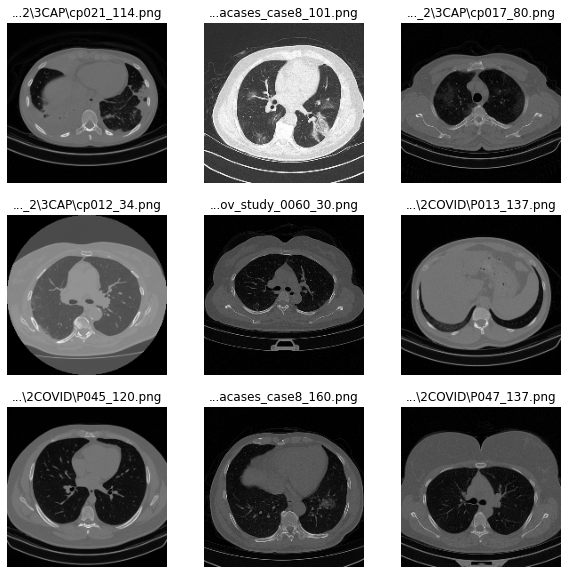

In [8]:
mf.check_dataset(train_ds)

In [9]:
import pandas as pd

In [14]:
covid_metadata = pd.read_csv ('datasets\ct_scan_3\meta_data_covid.csv')
non_covid_metadata = pd.read_csv ('datasets\ct_scan_3\meta_data_normal.csv')

In [16]:
covid_metadata.head()

,index,File name,Patient ID,Gender,Age,Country,Diagnosis,Slice,Case Discussion,Case Number,...,in_icu,intubated,intubation_present,license,mAs,mask_file,needed_supplemental_O2,study_file,survival,went_icu
0,0,6_Rahimzadeh_137covid_patient101_SR_4_IM00006.png,patient101,F,51,Iran,COVID-19,6.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,6_Rahimzadeh_137covid_patient101_SR_4_IM00008.png,patient101,F,51,Iran,COVID-19,8.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,6_Rahimzadeh_137covid_patient101_SR_4_IM00009.png,patient101,F,51,Iran,COVID-19,9.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,6_Rahimzadeh_137covid_patient101_SR_4_IM00010.png,patient101,F,51,Iran,COVID-19,10.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,6_Rahimzadeh_137covid_patient101_SR_4_IM00011.png,patient101,F,51,Iran,COVID-19,11.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
non_covid_metadata.head()

,index,File name,Patient ID,Gender,Age,Country,Diagnosis,Slice,Case Discussion,Case Number,...,in_icu,intubated,intubation_present,license,mAs,mask_file,needed_supplemental_O2,study_file,survival,went_icu
0,0,6_Rahimzadeh_normal10_patient151_SR_4_IM00012.png,patient151,F,43,Iran,Normal,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,6_Rahimzadeh_normal10_patient151_SR_4_IM00017.png,patient151,F,43,Iran,Normal,17,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,6_Rahimzadeh_normal10_patient151_SR_4_IM00022.png,patient151,F,43,Iran,Normal,22,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,6_Rahimzadeh_normal10_patient152_SR_4_IM00012.png,patient152,F,31,Iran,Normal,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,6_Rahimzadeh_normal10_patient152_SR_4_IM00017.png,patient152,F,31,Iran,Normal,17,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Cada um dos pascientes diagnosticado com covid ou vai para o dataset de treino ou para o dataset de validação

In [19]:
## Testando selecionar todas as imagens de um dado pasciente com covid
covid_metadata.head()

,index,File name,Patient ID,Gender,Age,Country,Diagnosis,Slice,Case Discussion,Case Number,...,in_icu,intubated,intubation_present,license,mAs,mask_file,needed_supplemental_O2,study_file,survival,went_icu
0,0,6_Rahimzadeh_137covid_patient101_SR_4_IM00006.png,patient101,F,51,Iran,COVID-19,6.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,6_Rahimzadeh_137covid_patient101_SR_4_IM00008.png,patient101,F,51,Iran,COVID-19,8.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,6_Rahimzadeh_137covid_patient101_SR_4_IM00009.png,patient101,F,51,Iran,COVID-19,9.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,6_Rahimzadeh_137covid_patient101_SR_4_IM00010.png,patient101,F,51,Iran,COVID-19,10.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,6_Rahimzadeh_137covid_patient101_SR_4_IM00011.png,patient101,F,51,Iran,COVID-19,11.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
covid_metadata['Patient ID'].unique()

array(['patient101', 'patient103', 'patient105', 'patient10',
       'patient115', 'patient117', 'patient118', 'patient119',
       'patient121', 'patient122', 'patient13', 'patient15', 'patient16',
       'patient17', 'patient18', 'patient1', 'patient20', 'patient22',
       'patient24', 'patient26', 'patient29', 'patient30', 'patient31',
       'patient32', 'patient34', 'patient35', 'patient3', 'patient43',
       'patient45', 'patient49', 'patient50', 'patient51', 'patient54',
       'patient57', 'patient58', 'patient59', 'patient61', 'patient63',
       'patient65', 'patient68', 'patient69', 'patient70', 'patient74',
       'patient75', 'patient76', 'patient78', 'patient7', 'patient81',
       'patient82', 'patient84', 'patient85', 'patient86', 'patient91',
       'patient92', 'patient96', 'patient97', 'patient98', 'patient99',
       'patient9', 'patient125', 'patient127', 'patient130', 'patient131',
       'patient133', 'patient136', 'patient140', 'patient141',
       'patient145

In [34]:
df.loc[df['Patient ID'] == 'patient103']

,index,File name,Patient ID,Gender,Age,Country,Diagnosis,Slice,Case Discussion,Case Number,...,in_icu,intubated,intubation_present,license,mAs,mask_file,needed_supplemental_O2,study_file,survival,went_icu
14,14,6_Rahimzadeh_137covid_patient103_SR_4_IM00016.png,patient103,M,41,Iran,COVID-19,16.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,15,6_Rahimzadeh_137covid_patient103_SR_4_IM00017.png,patient103,M,41,Iran,COVID-19,17.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,16,6_Rahimzadeh_137covid_patient103_SR_4_IM00018.png,patient103,M,41,Iran,COVID-19,18.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,17,6_Rahimzadeh_137covid_patient103_SR_4_IM00019.png,patient103,M,41,Iran,COVID-19,19.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,18,6_Rahimzadeh_137covid_patient103_SR_4_IM00020.png,patient103,M,41,Iran,COVID-19,20.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
df.loc[df['Patient ID'] == 'patient101']['File name'][0]

'6_Rahimzadeh_137covid_patient101_SR_4_IM00006.png'

In [32]:
from shutil import copy
base_src_folder = 'datasets\\ct_scan_3\\full-COVID-positive\\'
src = base_src_folder + df.loc[df['Patient ID'] == 'patient101']['File name'][0]
dst = 'datasets\\ct_scan_3\\train'
copy(src, dst)

'datasets\\ct_scan_3\\train\\6_Rahimzadeh_137covid_patient101_SR_4_IM00006.png'

In [23]:
len(covid_metadata['Patient ID'].unique())

464

In [81]:
def copy_all_images_from_one_patient(patient_id, src_folder, dst_folder, metadata):
   try:
      patient_dataset = metadata.loc[metadata['Patient ID'] == patient_id]
      files = patient_dataset['File name']
      for file in files:
         src = src_folder + '\\' + file
         copy(src, dst_folder)
   except Exception as e:
      print('Copy error: {}'.format(e))

In [37]:
patient_id = 'P040'
src_folder = 'datasets\\ct_scan_3\\full-COVID-positive'
dst_folder = 'datasets\\ct_scan_3\\train'
metadata = covid_metadata
copy_all_images_from_one_patient(patient_id, src_folder, dst_folder, metadata)

In [38]:
# Testando um split aleatório dos pacientes na esperança que a aleatoriedade salve a diferença de split final
covid_metadata['Patient ID'].unique()

array(['patient101', 'patient103', 'patient105', 'patient10',
       'patient115', 'patient117', 'patient118', 'patient119',
       'patient121', 'patient122', 'patient13', 'patient15', 'patient16',
       'patient17', 'patient18', 'patient1', 'patient20', 'patient22',
       'patient24', 'patient26', 'patient29', 'patient30', 'patient31',
       'patient32', 'patient34', 'patient35', 'patient3', 'patient43',
       'patient45', 'patient49', 'patient50', 'patient51', 'patient54',
       'patient57', 'patient58', 'patient59', 'patient61', 'patient63',
       'patient65', 'patient68', 'patient69', 'patient70', 'patient74',
       'patient75', 'patient76', 'patient78', 'patient7', 'patient81',
       'patient82', 'patient84', 'patient85', 'patient86', 'patient91',
       'patient92', 'patient96', 'patient97', 'patient98', 'patient99',
       'patient9', 'patient125', 'patient127', 'patient130', 'patient131',
       'patient133', 'patient136', 'patient140', 'patient141',
       'patient145

In [63]:
def random_split_patients(unique_patients_ids, validation_split):
   number_of_patients = len(unique_patients_ids)
   number_of_train_patients = int(number_of_patients * (1 - validation_split))
   
   np.random.shuffle(unique_patients_ids)
   train_patients_ids = unique_patients_ids[:number_of_train_patients]
   val_patients_ids = unique_patients_ids[number_of_train_patients:]
   
   return train_patients_ids, val_patients_ids

In [72]:
train_patients_ids, val_patients_ids = random_split_patients(covid_metadata['Patient ID'].unique(), 0.2)

In [75]:
len(train_patients_ids) + len(val_patients_ids) == len(covid_metadata['Patient ID'].unique())

True

---------------

In [92]:
train_covid_patients_ids, val_covid_patients_ids = random_split_patients(covid_metadata['Patient ID'].unique(), 0.2)

In [93]:
for patient in train_covid_patients_ids:
   copy_all_images_from_one_patient(
      patient_id=patient, 
      src_folder='datasets\\ct_scan_3\\full-COVID-positive', 
      dst_folder = 'datasets\\ct_scan_3\\train\\COVID-positive', 
      metadata = covid_metadata)

Copy error: [Errno 2] No such file or directory: 'datasets\\ct_scan_3\\full-COVID-positive\\17_Zhao_impact_of_covid19_infection_on_pregnancy_outcomes_and_the_risk_of_maternaltoneonatal_intrapartum_transmission_of_covid19_during_natural_birth-p8-41%5.png'
Copy error: [Errno 2] No such file or directory: 'datasets\\ct_scan_3\\full-COVID-positive\\17_Zhao_impact_of_covid19_infection_on_pregnancy_outcomes_and_the_risk_of_maternaltoneonatal_intrapartum_transmission_of_covid19_during_natural_birth-p8-41%1.png'
Copy error: [Errno 2] No such file or directory: 'datasets\\ct_scan_3\\full-COVID-positive\\17_Zhao_impact_of_covid19_infection_on_pregnancy_outcomes_and_the_risk_of_maternaltoneonatal_intrapartum_transmission_of_covid19_during_natural_birth-p8-41%3.png'


In [94]:
for patient in val_covid_patients_ids:
   copy_all_images_from_one_patient(
      patient_id=patient, 
      src_folder='datasets\\ct_scan_3\\full-COVID-positive', 
      dst_folder = 'datasets\\ct_scan_3\\val\\COVID-positive', 
      metadata = covid_metadata)

In [95]:
train_non_covid_patients_ids, val_non_covid_patients_ids = random_split_patients(non_covid_metadata['Patient ID'].unique(), 0.2)

In [96]:
for patient in train_non_covid_patients_ids:
   copy_all_images_from_one_patient(
      patient_id=patient, 
      src_folder='datasets\\ct_scan_3\\full-COVID-negative', 
      dst_folder = 'datasets\\ct_scan_3\\train\\COVID-negative', 
      metadata = non_covid_metadata)

In [97]:
for patient in val_non_covid_patients_ids:
   copy_all_images_from_one_patient(
      patient_id=patient, 
      src_folder='datasets\\ct_scan_3\\full-COVID-negative', 
      dst_folder = 'datasets\\ct_scan_3\\val\\COVID-negative', 
      metadata = non_covid_metadata)

In [98]:
5462 + 6307 + 1431 + 1283 == 6893 + 7590

True

In [104]:
train_ds = tf.keras.utils.image_dataset_from_directory(
   'datasets/ct_scan_3/train',
   labels='inferred',
   label_mode='int',
   class_names=None,
   color_mode='rgb',
   batch_size=batch_size,
   image_size=image_size,
   shuffle=True, 
   seed=100, 
   interpolation='lanczos3', 
   follow_links=False,
   crop_to_aspect_ratio=False)

Found 11769 files belonging to 2 classes.


In [105]:
val_ds = tf.keras.utils.image_dataset_from_directory(
   'datasets/ct_scan_3/val',
   labels='inferred',
   label_mode='int',
   class_names=None,
   color_mode='rgb',
   batch_size=batch_size,
   image_size=image_size,
   shuffle=True, 
   seed=100, 
   interpolation='lanczos3', 
   follow_links=False,
   crop_to_aspect_ratio=False)

Found 2714 files belonging to 2 classes.


In [101]:
2714 / 11769 

0.23060582887246156

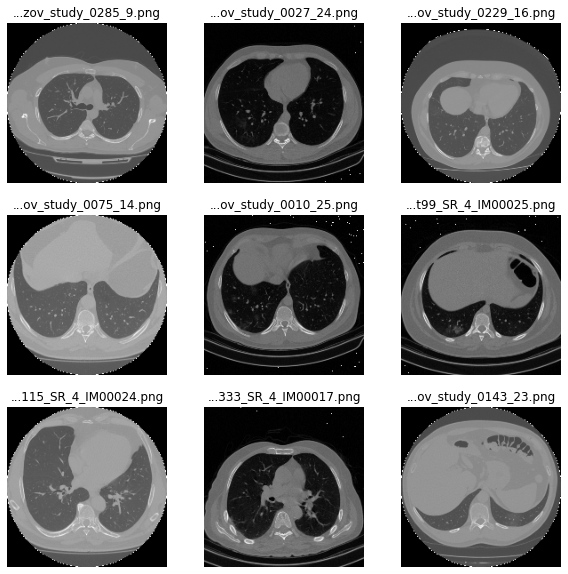

In [102]:
mf.check_dataset(train_ds)

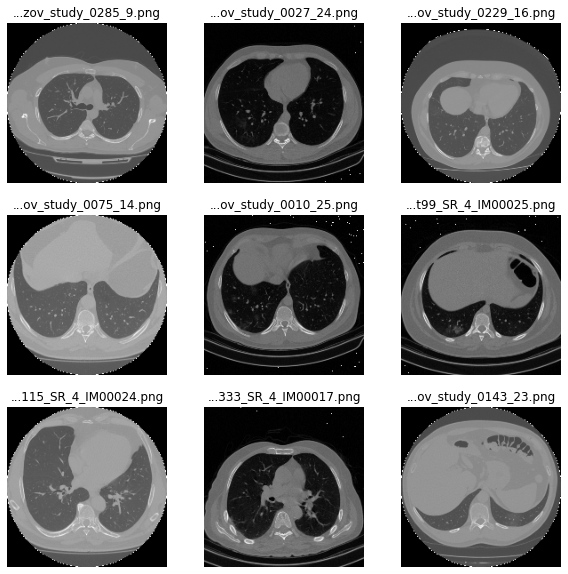

In [106]:
mf.check_dataset(val_ds)